# Colorization Bayesian CNN Faces Experiment Notebook

*** TO RUN ***

  - To run with bayesian neural network, git pull https://github.com/kumar-shridhar/PyTorch-BayesianCNN. 
  - Make sure "layers/" folder is in same file as notebook

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os, sys

import math
import utils
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2

In [2]:
from layers import BBB_MCMF_LRT_Linear, BBB_MCMF_LRT_Conv2d
from layers import FlattenLayer, ModuleWrapper
from layers.misc import ModuleWrapper
# from models.BayesianModels.BayesianAlexNet import BBBAlexNet

In [15]:
class colordata(Dataset):
    def __init__(self, basedir, listdir, shape=(32,32), obs_num=400, split='train'):

        self.img_fns = []
        
        self.basedir = basedir
        with open('%s/list.%s.vae.txt' % (os.path.join(basedir, listdir), split), 'r') as ftr:
            for img_fn in ftr:
                self.img_fns.append(img_fn.strip('\n'))

        self.img_num = len(self.img_fns)
        self.shape = shape

    def __len__(self):
        return self.img_num
 
    def __getitem__(self, idx):

        img_large = cv2.imread(os.path.join(self.basedir, self.img_fns[idx]))
        if self.shape is not None:
            img = cv2.resize(img_large, (self.shape[0], self.shape[1]))

        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) # convert to lab color space
        img_lab = ((img_lab) / 255.) #normalizing
        img_lab = torch.from_numpy(img_lab)

        color_ab = torch.stack(
            (img_lab[..., 1], img_lab[..., 2]), dim=0)
        
        return color_ab, img_lab[..., 0].unsqueeze(0)



In [16]:
class BBBAE_simple(ModuleWrapper):
    '''The architecture of AE'''

    def __init__(self, outputs, inputs, layer_type='mcmf_lrt', activation_type='softplus'):
        super(BBBAE_simple, self).__init__()

        self.num_classes = outputs
        self.layer_type = layer_type

        if layer_type=='mcmf_lrt':
            BBBLinear = BBB_MCMF_LRT_Linear
            BBBConv2d = BBB_MCMF_LRT_Conv2d
        elif layer_type=='lrt':
            BBBLinear = BBB_LRT_Linear
            BBBConv2d = BBB_LRT_Conv2d
        else:
            raise ValueError("Undefined layer_type")
        
        if activation_type=='softplus':
            self.act = nn.Softplus
        elif activation_type=='relu':
            self.act = nn.ReLU
        else:
            raise ValueError("Only softplus or relu supported")

        self.conv1 = BBBConv2d(inputs, 64, 3, stride=1, padding=1, bias=True)
        self.conv1_pool = BBBConv2d(64, 128, 3, stride=2, padding=1, bias=True)
        self.act1 = self.act()
        # Shape 16x16
        
        self.conv2_pool = BBBConv2d(128, 256, 3, stride=2, padding=1, bias=True)
        self.act2 = self.act()
        # Shape 8x8
        
        self.up2 = nn.Upsample(size=(16,16), mode='nearest')
        self.conv2_up = BBBConv2d(256, 256, 3, stride=1, padding=1, bias=True)
        # Shape 16x16
        
        self.up1 = nn.Upsample(size=(32,32), mode='nearest')
        self.conv1_up = BBBConv2d(256, 256, 3, stride=1, padding=1, bias=True)
        self.conv1_up2 = BBBConv2d(256, outputs*2, 3, stride=1, padding=1, bias=True)
#         if outputs == 3 or outputs == 1:
#             self.act1_up = nn.Sigmoid()
        # outputs*2x32x32

################################################
# Forward function is defined by ModuleWrapper #
################################################

In [17]:
def decodeimg(img_enc):
    img_dec = img_enc*255.
    img_dec[img_dec < 0.] = 0.
    img_dec[img_dec > 255.] = 255.
    return cv2.resize(np.uint8(img_dec), (32,32))

def visualize(gray_c, color_c, outputs_a, outputs_b, image=0, sigmoid_input=False):
    img_dim = gray_c[0].shape[1]
    
    img_lab = np.zeros((img_dim,img_dim,3), dtype='uint8') 
    img_lab[:,:,0] = decodeimg(gray_c[image].cpu().numpy().reshape((img_dim, img_dim)))
    img_lab[:,:,1] = decodeimg(color_c[image][0].cpu().numpy().reshape((img_dim, img_dim)))
    img_lab[:,:,2] = decodeimg(color_c[image][1].cpu().numpy().reshape((img_dim, img_dim)))
    
    pred_img_lab = np.zeros((img_dim,img_dim,3), dtype='uint8') 
    pred_img_lab[:,:,0] = decodeimg(gray_c[image].cpu().numpy().reshape((img_dim, img_dim)))
    if sigmoid_input:
        pred_img_lab[:,:,1] = decodeimg(outputs_a[image].cpu().numpy().reshape((img_dim, img_dim)))
        pred_img_lab[:,:,2] = decodeimg(outputs_b[image].cpu().numpy().reshape((img_dim, img_dim)))       
    else:
        pred_img_lab[:,:,1] = outputs_a[image].cpu().numpy().reshape((img_dim, img_dim))
        pred_img_lab[:,:,2] = outputs_b[image].cpu().numpy().reshape((img_dim, img_dim))

    gt_img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    output_img = cv2.cvtColor(pred_img_lab, cv2.COLOR_LAB2RGB)

    plt.subplot(121)
    plt.axis('off'), plt.title("GT Image")
    plt.imshow(gt_img)
    plt.subplot(122)
    plt.axis('off'), plt.title("Output")
    plt.imshow(output_img)
    plt.show()

# Load color data faces

In [6]:
basedir = '../pytorch_divcolor/'
listdir = 'data/imglist/lfw/'

data_train = colordata(shape = (32,32), basedir=basedir,
                       listdir=listdir, obs_num = 400, split='train')

train_loader = DataLoader(dataset=data_train, num_workers=1,
                          batch_size=32, shuffle=True, drop_last=True)

data_test = colordata(shape = (32,32), basedir=basedir,
    listdir=listdir, obs_num = 400, split='test')

test_loader = DataLoader(dataset=data_test, num_workers=1,
                         batch_size=32, shuffle=True, drop_last=True)

In [7]:
for i, (color_c, gray_c) in enumerate(train_loader):
    print("Color channels (AB) image:")
    print("    ", color_c.shape)
    print("Gray channel (L) image:")
    print("    ", gray_c.shape)
    break

Color channels (AB) image:
     torch.Size([32, 2, 32, 32])
Gray channel (L) image:
     torch.Size([32, 1, 32, 32])


# NLL Loss with 256 color classification model

In [8]:
input_size = 1 # L (grayscale) channel
output_size = 256
model = BBBAE_simple(output_size, input_size).cuda()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Epoch  0
Loss NLL:  146.0165976604242


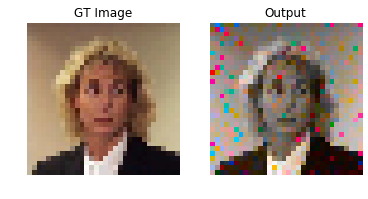

Epoch  1
Loss NLL:  11.661537624778548


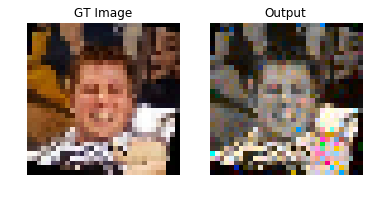

Epoch  2
Loss NLL:  9.870564148688192


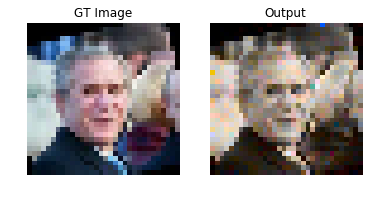

Epoch  3
Loss NLL:  9.259623549995622


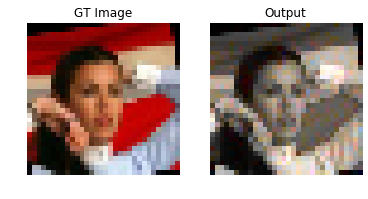

Epoch  4
Loss NLL:  8.908500491636586


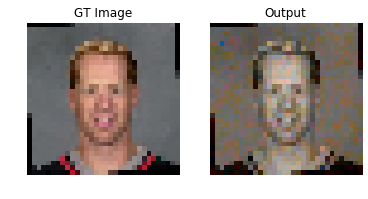

Epoch  5
Loss NLL:  8.664467996327664


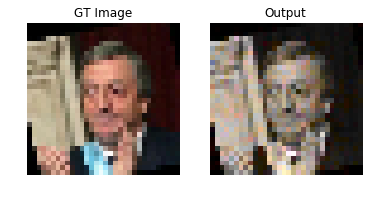

Epoch  6
Loss NLL:  8.484114936509057


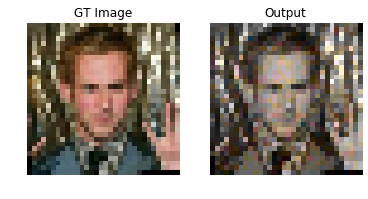

Epoch  7
Loss NLL:  8.335921479769402


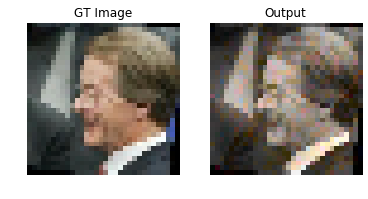

Epoch  8
Loss NLL:  8.211763875022609


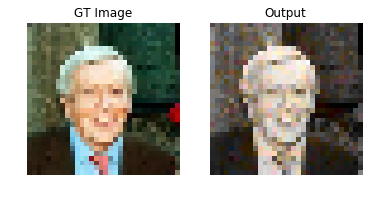

Epoch  9
Loss NLL:  8.105681600370957


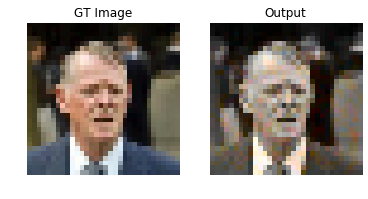

Epoch  10
Loss NLL:  8.006450811605802


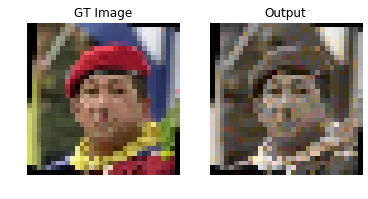

Epoch  11
Loss NLL:  7.918640910642933


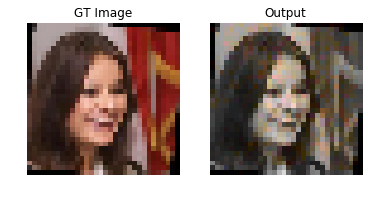

Epoch  12
Loss NLL:  7.836613291845271


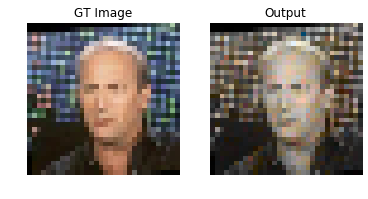

Epoch  13
Loss NLL:  7.763678063896938


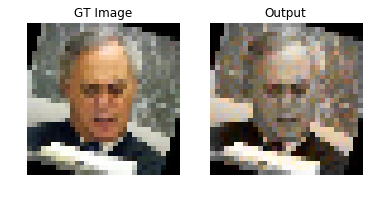

Epoch  14
Loss NLL:  7.691381116188009


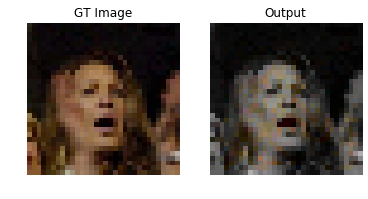

Epoch  15
Loss NLL:  7.62602109434717


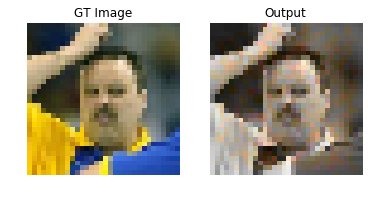

Epoch  16
Loss NLL:  7.565985643426785


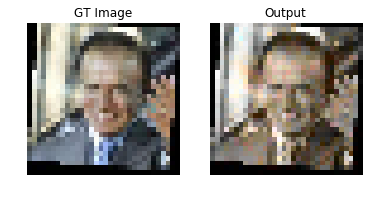

Epoch  17
Loss NLL:  7.509435663672642


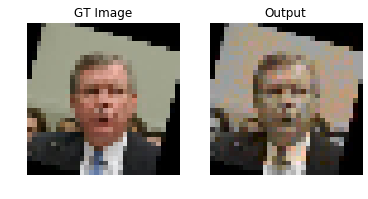

Epoch  18
Loss NLL:  7.454837694218021


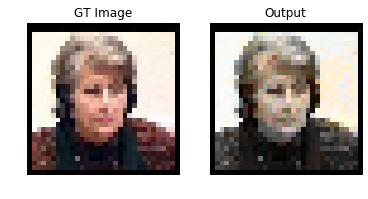

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [9]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 1000

for epoch in range(epochs):  
    loss_ = 0.
    for i, (color_c, gray_c) in enumerate(train_loader):
        color_c, gray_c = color_c.cuda().float(), gray_c.cuda().float()
        bs = color_c.shape[0]
        optimizer.zero_grad()
        
        # Average multiple results (ensembling)
        ens_num = 1
        outputs = torch.zeros(bs, 256*2, 32, 32, ens_num).cuda()
        for j in range(ens_num):
            gen_image = model(gray_c)[0]
            outputs[:,:256,:,:,j] = F.log_softmax(gen_image[:,:256],1)
            outputs[:,256:,:,:,j] = F.log_softmax(gen_image[:,256:],1)
            outputs_a = torch.mean(outputs[:,:256],4)
            outputs_b = torch.mean(outputs[:,256:],4)

        loss = (F.nll_loss(outputs_a, (color_c[:,0,:,:]*255).long()) # A channel
                + F.nll_loss(outputs_b, (color_c[:,1,:,:]*255).long())) # B channel
        loss.backward()
        optimizer.step()
        loss_ += loss.item()

    if epoch % 1 == 0:
        print("Epoch ", epoch)
        print("Loss NLL: ", loss_/(i+1))
        visualize(gray_c.detach(), color_c.detach(), 
                  torch.argmax(outputs_a,1).detach(), torch.argmax(outputs_b,1).detach())

## Ensembling on Test set

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Loss NLL:  7.106949806213379


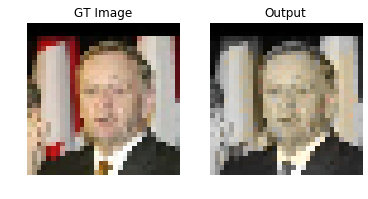

Loss NLL:  6.562895774841309


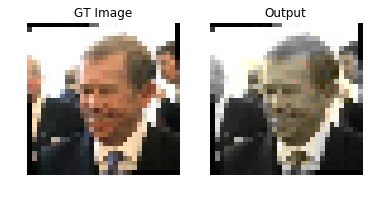

Loss NLL:  7.355135917663574


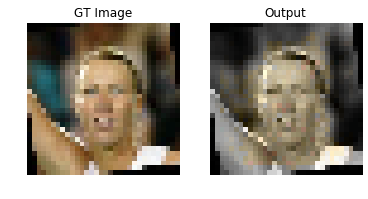

Loss NLL:  7.18317985534668


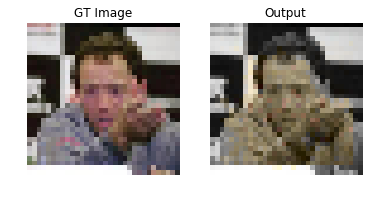

Loss NLL:  5.960984230041504


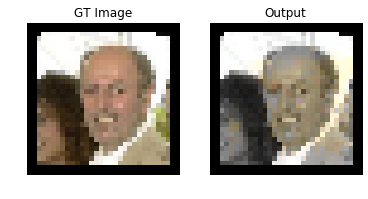

Loss NLL:  6.767691612243652


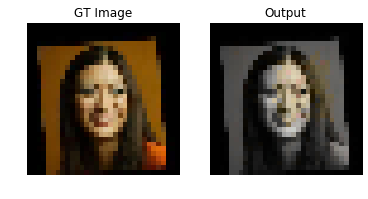

Loss NLL:  7.860167503356934


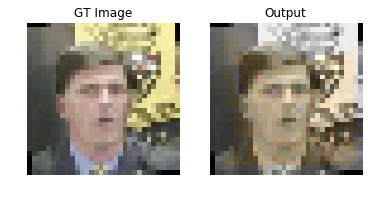

Loss NLL:  7.702907085418701


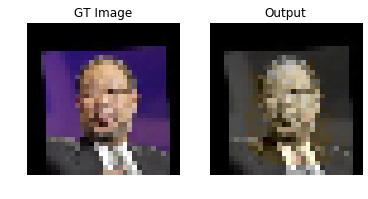

Loss NLL:  7.710990905761719


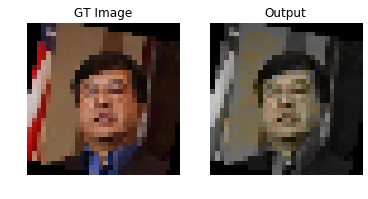

Loss NLL:  7.52376651763916


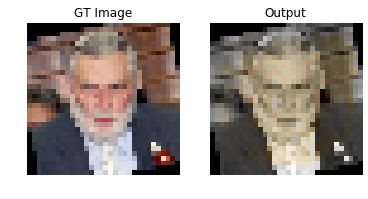

Loss NLL:  7.34443473815918


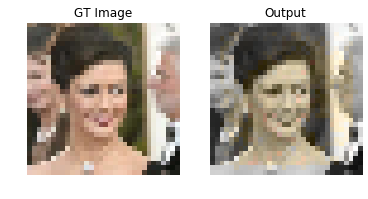

Loss NLL:  7.287895202636719


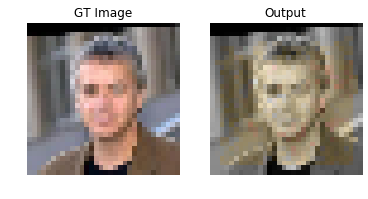

Loss NLL:  8.201385498046875


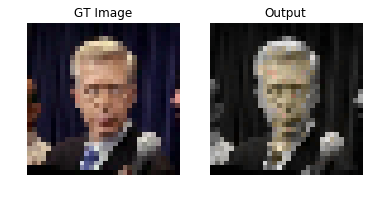

Loss NLL:  7.4096879959106445


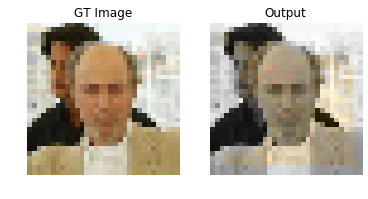

Loss NLL:  8.935611724853516


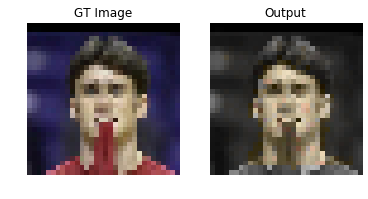

Loss NLL:  7.563480377197266


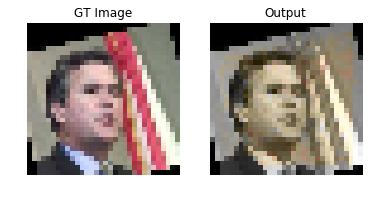

Loss NLL:  5.739240646362305


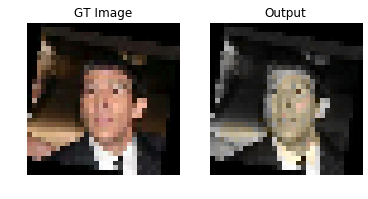

Loss NLL:  8.058123588562012


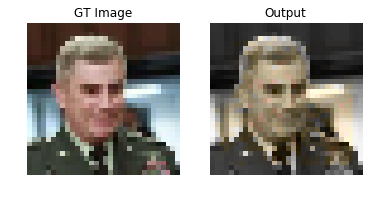

Loss NLL:  9.20826244354248


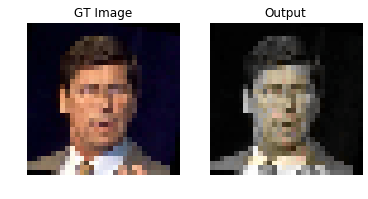

Loss NLL:  7.587787628173828


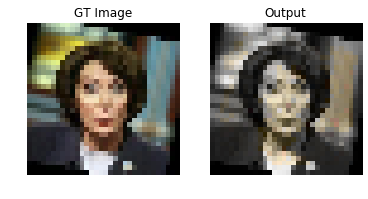

In [10]:
for i, (color_c, gray_c) in enumerate(test_loader):
    if i < 20:
        color_c, gray_c = color_c.cuda().float(), gray_c.cuda().float()
        bs = color_c.shape[0]
        optimizer.zero_grad()
        
        # Average multiple results (ensembling)
        ens_num = 10
        outputs = torch.zeros(bs, 256*2, 32, 32, ens_num).cuda()
        for j in range(ens_num):
            gen_image = model(gray_c)[0]
            outputs[:,:256,:,:,j] = F.log_softmax(gen_image[:,:256],1)
            outputs[:,256:,:,:,j] = F.log_softmax(gen_image[:,256:],1)
            outputs_a = torch.mean(outputs[:,:256],4)
            outputs_b = torch.mean(outputs[:,256:],4)

        loss = (F.nll_loss(outputs_a, (color_c[:,0,:,:]*255).long()) # A channel
                + F.nll_loss(outputs_b, (color_c[:,1,:,:]*255).long())) # B channel

        print("Loss NLL: ", loss.item())
        visualize(gray_c.detach(), color_c.detach(), 
                  torch.argmax(outputs_a,1).detach(), torch.argmax(outputs_b,1).detach())

# MSE Loss with single value outputs for AB channels

## Overfitting to one example

In [11]:
input_size = 1 # L (grayscale) channel
output_size = 1
model = BBBAE_simple(output_size, input_size).cuda()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch  0
Loss MSE:  0.017056051641702652


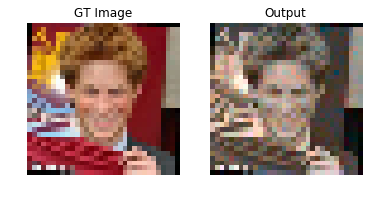

Epoch  100
Loss MSE:  0.008906235918402672


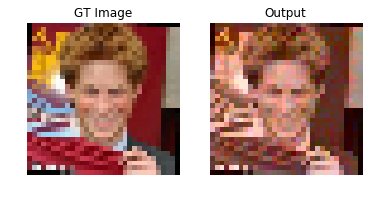

Epoch  200
Loss MSE:  0.008289585821330547


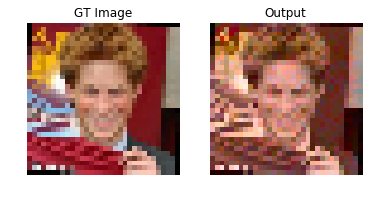

Epoch  300
Loss MSE:  0.0074715381488204


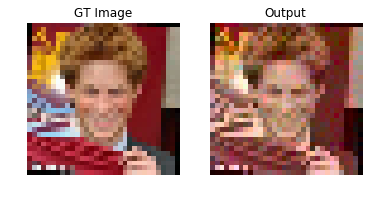

Epoch  400
Loss MSE:  0.007328178733587265


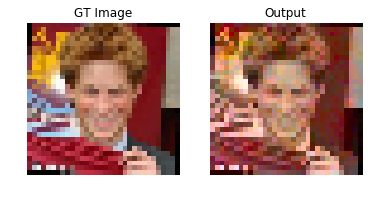

Epoch  500
Loss MSE:  0.006001840345561504


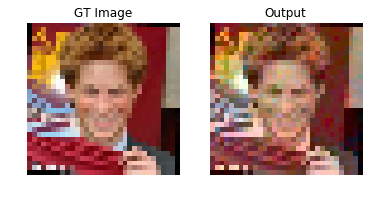

Epoch  600
Loss MSE:  0.005613407120108604


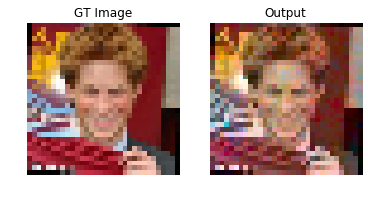

Epoch  700
Loss MSE:  0.005529859568923712


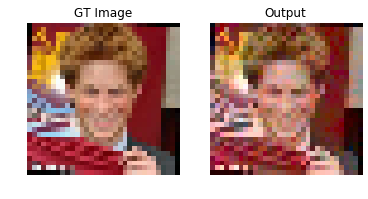

Epoch  800
Loss MSE:  0.005250593181699514


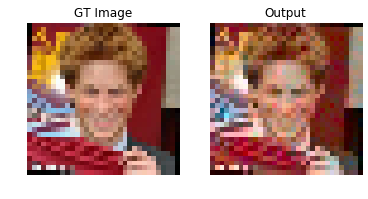

Epoch  900
Loss MSE:  0.004944338463246822


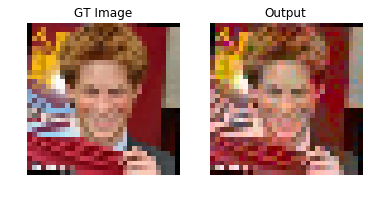

In [22]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 1000

for i, (color_c, gray_c) in enumerate(train_loader):
    break
# Choose first example to overfit
color_c, gray_c = color_c[0:1].cuda().float(), gray_c[0:1].cuda().float()
    
for epoch in range(epochs):  
    loss_ = 0.
    
    bs = color_c.shape[0]
    optimizer.zero_grad()

    # Average multiple results (ensembling)
    ens_num = 1
    outputs = torch.zeros(bs, 2, 32, 32, 5).cuda()
    for j in range(ens_num):
        gen_image = model(gray_c)[0]
        outputs[:,:1,:,:,j] = gen_image[:,:1]
        outputs[:,1:,:,:,j] = gen_image[:,1:]

    outputs_a = torch.mean(outputs[:,:1],4)
    outputs_b = torch.mean(outputs[:,1:],4)

#     loss = (criterion(outputs_a, (color_c[:,:1,:,:])) # A-channel loss
#             + criterion(outputs_b, (color_c[:,1:,:,:]))) # B-channel loss

    loss = (criterion(F.sigmoid(outputs_a), (color_c[:,:1,:,:])) # A-channel loss
            + criterion(F.sigmoid(outputs_b), (color_c[:,1:,:,:]))) # B-channel loss

    loss.backward()
    optimizer.step()
    loss_ += loss.item()

    if epoch % 100 == 0:
        print("Epoch ", epoch)
        print("Loss MSE: ", loss_/(i+1))
#         visualize(gray_c.detach(), color_c.detach(), 
#                   outputs_a.detach(), outputs_b.detach())        
        visualize(gray_c.detach(), color_c.detach(), 
                  F.sigmoid(outputs_a).detach(), F.sigmoid(outputs_b).detach(), sigmoid_input=True)

## Train on all data

In [8]:
input_size = 1 # L (grayscale) channel
output_size = 1
model = BBBAE_simple(output_size, input_size).cuda()

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 1000

for epoch in range(epochs):  
    loss_ = 0.
    for i, (color_c, gray_c) in enumerate(train_loader):
        color_c, gray_c = color_c.cuda().float(), gray_c.cuda().float()
        bs = color_c.shape[0]
        optimizer.zero_grad()
        
        # Average multiple results (ensembling)
        ens_num = 1
        outputs = torch.zeros(bs, 2, 32, 32, 5).cuda()
        for j in range(ens_num):
            gen_image = model(gray_c)[0]
            outputs[:,:1,:,:,j] = gen_image[:,:1]
            outputs[:,1:,:,:,j] = gen_image[:,1:]
            
        outputs_a = torch.mean(outputs[:,:1],4)
        outputs_b = torch.mean(outputs[:,1:],4)

        loss = (criterion(outputs_a, (color_c[:,:1,:,:])) # A-channel loss
                + criterion(outputs_b, (color_c[:,1:,:,:]))) # B-channel loss
        loss.backward()
        optimizer.step()
        loss_ += loss.item()

    if epoch % 1 == 0:
        print("Epoch ", epoch)
        print("Loss MSE: ", loss_/(i+1))
        visualize(gray_c.detach(), color_c.detach(), 
                  outputs_a.detach(), outputs_b.detach())

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


KeyboardInterrupt: 